# 正则化logistic regression

我们有非常多的特征时，通过学习得到的假设可能能够非常好地适应训练集，但泛化能力较差，即**过拟合问题**  
解决方法：  
1.丢弃一些不能帮助我们正确预测的特征。可以是手工选择保留哪些特征，或者使用一些模型选择的算法来帮忙（例如 PCA）  
2.正则化，保留所有的特征，但是减少参数的大小

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [2]:
path = 'ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['test1', 'test2', 'accepted'])
data2.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


数据可视化

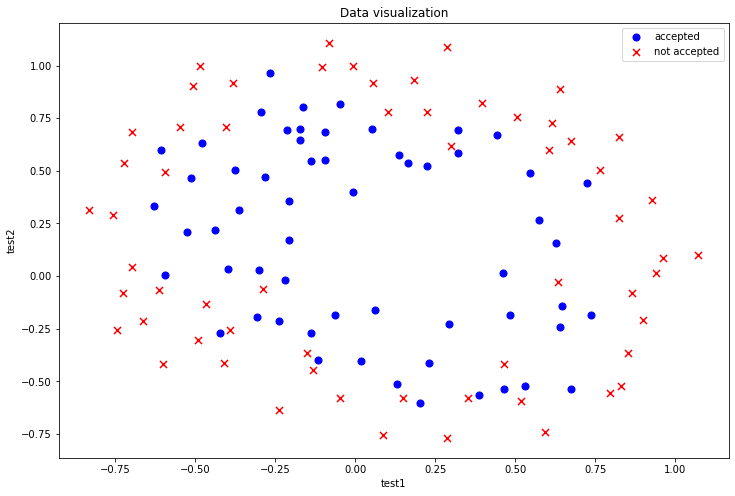

In [3]:
positive = data2[data2['accepted'].isin([1])]
negative = data2[data2['accepted'].isin([0])]
plt.figure(figsize=(12, 8))
plt.xlabel('test1')
plt.ylabel('test2')
plt.title('Data visualization')
plt.scatter(positive['test1'], positive['test2'], s=50, c='b',marker='o',label='accepted' )
plt.scatter(negative['test1'], negative['test2'], s=50, c='r',marker='x',label='not accepted' )
plt.legend()
plt.show()

创建一组多项式特征
$${{h}_{\theta }}\left( x \right)=g\left( {{\theta}_{0}+{\theta}_{1}{x}_{1}+{\theta}_{2}{x}_{2}+{\theta}_{3}{x}_{1}{x}_{2}+{\theta}_{4}{x}_{1}^{2}+{\theta}_{5}{x}_{2}^{2}+{\theta}_{6}{x}_{1}^{2}{x}_{2}+{\theta}_{7}{x}_{1}{x}_{2}^{2}+{\theta}_{8}{x}_{1}^{2}{x}_{2}^{2}} \right)$$
其中
$$g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$$

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
degree = 3
x1 = data2['test1']
x2 = data2['test2']
#data2.insert(3, 'Ones', 1)

for i in range(0, degree):
    for j in range(0, degree):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('test1', axis=1, inplace=True)#删除原数据列
data2.drop('test2', axis=1, inplace=True)

data2.head()

,accepted,F00,F01,F02,F10,F11,F12,F20,F21,F22
0,1,1.0,13.645425,186.197622,0.051267,0.69956,9.545793,0.002628,0.035864,0.489384
1,1,1.0,-7.385435,54.544648,-0.092742,0.68494,-5.058580,0.008601,-0.063523,0.469143
2,1,1.0,-3.239203,10.492434,-0.213710,0.69225,-2.242338,0.045672,-0.147941,0.479210
3,1,1.0,-1.339173,1.793385,-0.375000,0.50219,-0.672519,0.140625,-0.188321,0.252195
4,1,1.0,-0.907238,0.823081,-0.513250,0.46564,-0.422446,0.263426,-0.238990,0.216821


初始化变量

In [6]:
cols = data2.shape[1]
X = data2.iloc[:,1:cols]
y = data2.iloc[:,0:1]

X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(cols-1)

In [7]:
X.shape,y.shape,theta.shape

((118, 9), (118, 1), (9,))

# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [8]:
def costReg(theta, X, y, lamda):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (lamda / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))#theta_0不计算入内
    return np.sum(first - second) / len(X) + reg

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$


In [9]:
def gradientReg(theta, X, y, lamda):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((lamda / len(X)) * theta[:,i])
    
    return grad

初始化正则化参数

In [10]:
lamda = 1

In [11]:
costReg(theta, X, y, lamda)

0.6931471805599454

In [12]:
gradientReg(theta, X, y, lamda)

array([ 8.47457627e-03, -4.46498732e-02,  8.67280480e+01,  1.87880932e-02,
        7.77711864e-05, -4.70785882e-01,  5.03446395e-02,  1.15013308e-02,
        3.76648474e-02])

高级参数优化

In [14]:
w = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(X, y, lamda))
w

(array([ 1.17640822e+00, -1.06112160e-01, -7.01557528e-04,  3.58136993e-01,
         7.29168562e-01,  3.12364874e-02, -2.76143010e+00, -6.68633676e-01,
        -2.40519667e+00]),
 43,
 1)

分类预测函数

In [16]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

计算预测准确率

In [17]:
theta_min = np.matrix(w[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 94%
